In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image as im

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 50})

In [2]:
par_folder = "/home/tigeriv/Data/Carla/Cartesian/Test"
n_classes = 11

models = ["SMNet", "ConvBKI"]
# models = ["SMNetLSTM", "SMNet", "SMNetLinear", "SMNetLSTM_One", "SMNet_One", "SMNetLinear_One", "ConvBKI"]

model_ints = {}
model_uns = {}
model_preds = {}
for model in models:
    model_ints[model] = np.zeros(n_classes)
    model_uns[model] = np.zeros(n_classes)
    model_preds[model] = []
all_gt = []

In [3]:
def iou_one_frame(pred, target, n_classes=11):
    pred = np.argmax(pred, axis=1)
    intersection = np.zeros(n_classes)
    union = np.zeros(n_classes)

    for cls in range(n_classes):
        intersection[cls] = np.sum((pred == cls) & (target == cls))
        union[cls] = np.sum((pred == cls) | (target == cls))
    return intersection, union

In [4]:
for scene in os.listdir(par_folder):
    print(scene)
    folder = os.path.join(par_folder, scene, "cartesian")
    mask_path = os.path.join(folder, "mask")
    model_dirs = {models[i]: os.path.join(folder, models[i]) for i in range(len(models))}
    for frame_name in sorted(os.listdir(mask_path)):
        gt = np.fromfile(os.path.join(folder, "bev_gt", frame_name), dtype=np.uint8).reshape(256, 256)
        mask = np.fromfile(os.path.join(mask_path, frame_name), dtype=np.uint8).reshape(256, 256)
        in_gt = gt[mask==1]
        out_gt = gt[mask==0]
        non_zero_mask = in_gt != 0
        in_gt = in_gt[non_zero_mask]
        all_gt += list(in_gt)
        for model in models:
            preds = np.fromfile(os.path.join(model_dirs[model], frame_name), dtype=np.float32).reshape(256, 256, n_classes)
            in_preds = preds[mask==1]
            out_preds = preds[mask==0]
            in_preds = in_preds[non_zero_mask]
            intersection, union = iou_one_frame(in_preds, in_gt, n_classes=n_classes)
            model_ints[model] += intersection
            model_uns[model] += union
            model_preds[model] += list(np.argmax(in_preds, axis=1))

Town10_Light
Town10_Heavy
Town10_Medium


In [5]:
for model in models:
    print(model)
    iou = 100 * model_ints[model] / model_uns[model]
    for i in range(iou.shape[0]):
        print(iou[i])

SMNet
nan
29.383444485018547
1.2166520082087364
19.427849065752334
19.939846641988368
35.681865071178045
85.77901315895178
5.017472096570974
64.20054510139192
56.107598754000186
37.67681018384577
ConvBKI
0.0
23.754256593316267
1.2402935857887458
17.118826241226593
10.105352632998505
21.525592817128388
76.7885129280157
4.861961763434108
39.72739775581439
52.25623138153323
19.435402274065535


/tmp/ipykernel_1396153/3305195109.py:3: RuntimeWarning: invalid value encountered in true_divide
  iou = 100 * model_ints[model] / model_uns[model]


In [6]:
COLOR_MAP = {
    0: "Free",
    1: "Building",
    2: "Barrier",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Road",
    7: "Ground",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Vehicle"
}

all_labels = [COLOR_MAP[i] for i in range(1, n_classes)]

def class_to_label(preds):
    labels = [COLOR_MAP[preds[i]] for i in range(len(preds))]
    return labels

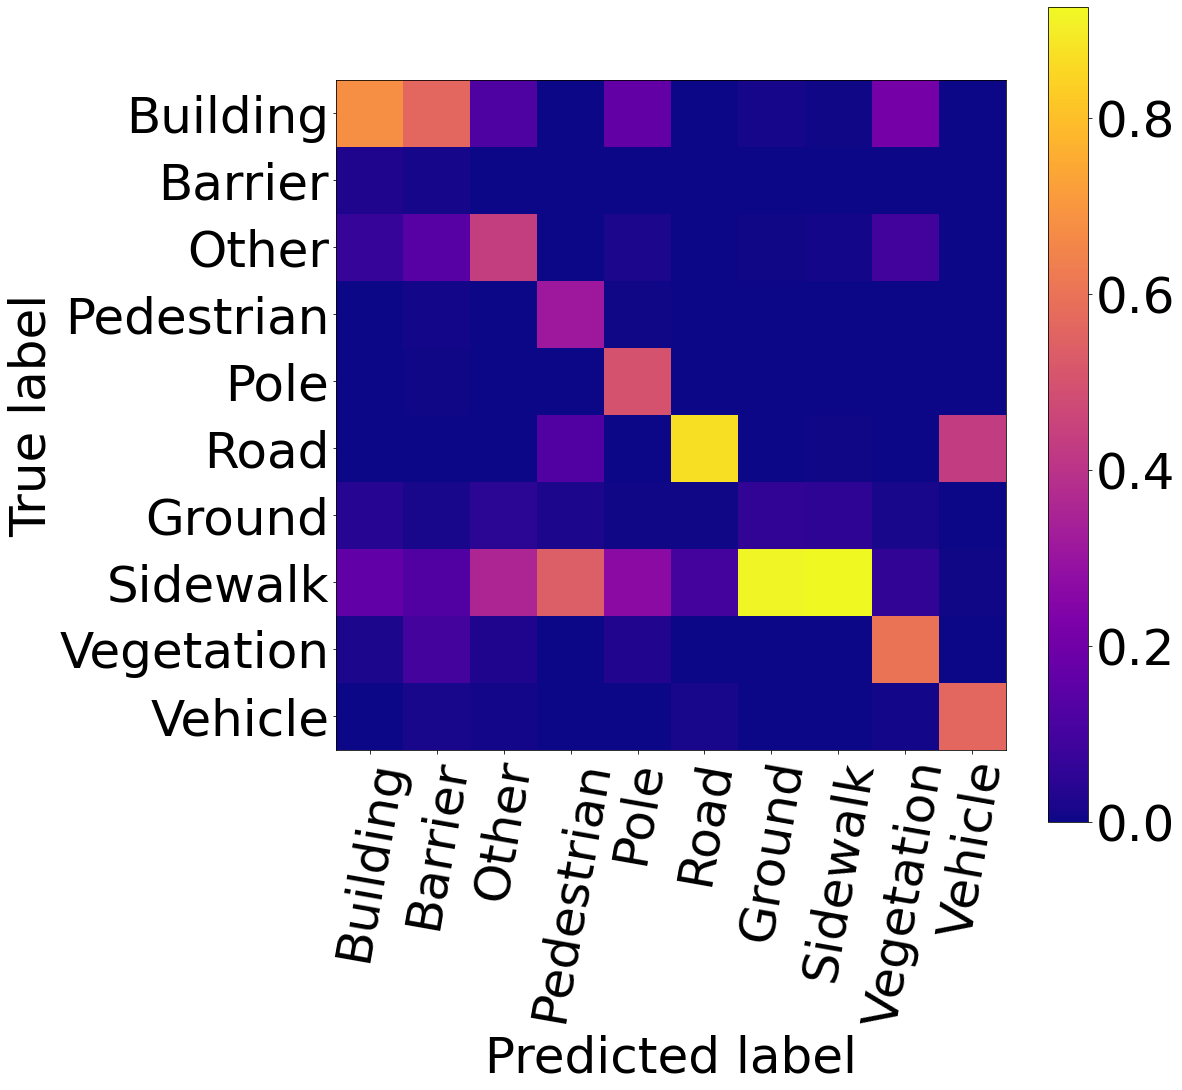

In [7]:
classes = np.array([i for i in range(1, n_classes)])

disp = ConfusionMatrixDisplay.from_predictions(np.array(all_gt), np.array(model_preds[models[0]]),
                                               labels=classes, normalize="pred", include_values=False,
                                              cmap='plasma')
kept_classes = np.array([i for i in range(n_classes - 1)])
plt.xticks(kept_classes, all_labels, rotation=80)
plt.yticks(kept_classes, all_labels)
plt.show()

In [8]:
conf = confusion_matrix(np.array(all_gt), np.array(model_preds[models[0]]))[:, :]

In [9]:
precisions = []
recalls = []
for i in range(conf.shape[0]):
    tp = conf[i, i]
    fp = np.sum(conf[:, i]) - tp
    fn = np.sum(conf[i, :]) - tp
    precision_i = tp / (tp + fp)
    recall_i = tp / (tp + fn)
    precisions.append(precision_i)
    recalls.append(recall_i)
print(all_labels)
print("precision")
for i in range(conf.shape[0]):
    print(precisions[i] * 100)
print("recall")
for i in range(conf.shape[0]):
    print(recalls[i] * 100)

['Building', 'Barrier', 'Other', 'Pedestrian', 'Pole', 'Road', 'Ground', 'Sidewalk', 'Vegetation', 'Vehicle']
precision
67.72239510082944
1.3230886947650322
43.529487842731506
31.420238529243267
50.137701116103784
87.25023750549329
6.063339340819291
92.5937628152185
60.32054802880508
56.51306004741935
recall
34.168636193477376
13.137068692624249
25.974316627822624
35.30547752808989
55.30860249440358
98.0721339083808
22.53372349080191
67.67581124061188
88.93000134958837
53.06024935365103
